In [394]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from src import mrio

In [283]:
input_mrio = '../data/mrio.parquet'
input_ee = '../data/ee.parquet'

years = [2017, 2018, 2019, 2020, 2021]

## Industrial Sectors

**Objectives**

1. Defining emission intensive and trade exposed sectors
2. Quantifying carbon leakage risk


#### A. Emission Intensity
Volume of a country-sector's GHG emissions (direct + indirect) / country-sector's GVA
* *Direct emissions* - from a country-sector's production
* *Indirect emissions* - from the production of a country-sector's inputs

In [375]:
df = duckdb.sql(f"SELECT * FROM '{input_ee}' LIMIT 5").df()
labels = df.columns[4:2559].to_frame(index=False)[0].str.split("_", expand=True)
labels = labels.set_axis(['country', 'sector'], axis=1)

In [382]:
dfs = []
for year in years: 
    data_ee = mrio.EE(f'{input_ee}', year)
    data_mrio = mrio.MRIO(f'{input_mrio}', year, full=True)

    # direct emissions
    direct = data_ee.E

    # indirect emissions
    e = data_ee.E @ (1/data_mrio.x).diag()
    B = data_mrio.B
    Z = data_mrio.Z
    indirect = (e @ B) @ Z

    # total emissions
    total = direct + indirect
    total = np.array(total.data.tolist()[0])   

    # emission intensity
    gva = data_mrio.va
    gva = np.array(gva.data.tolist())

    d_ei = np.array(direct.data.tolist()[0]) / gva
    i_ei = np.array(indirect.data.tolist()[0]) / gva
    ei = total / gva

    emissions_dict = {
        'year': year,
        'direct': direct.data.tolist()[0],
        'indirect': indirect.data.tolist()[0],
        'total': total.tolist(),
        'gva': gva.tolist(),
        'd_ei': d_ei.tolist(),
        'i_ei': i_ei.tolist(),
        'ei': ei.tolist()
    }

    year_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
    dfs.append(year_df)
    
em_df = pd.concat(dfs, ignore_index=True)

In [425]:
sectors = [f"c{i}" for i in range(6, 16+1)]
industry_df = em_df[em_df['sector'].isin(sectors)]
industry_df

,country,sector,year,direct,indirect,total,gva,d_ei,i_ei,ei
5,AUS,c6,2017,1935.206125,7266.369181,9201.575306,2887.853870,0.670119,2.516183,3.186302
6,AUS,c7,2017,874.312397,10094.311674,10968.624071,9779.082025,0.089406,1.032235,1.121641
7,AUS,c8,2017,24160.665271,11982.498704,36143.163975,4551.511972,5.308272,2.632641,7.940914
8,AUS,c9,2017,9224.167860,7326.838694,16551.006554,6275.871857,1.469783,1.167461,2.637244
9,AUS,c10,2017,569.602247,5527.060653,6096.662900,3686.041738,0.154530,1.499457,1.653986
...,...,...,...,...,...,...,...,...,...,...
12751,RoW,c12,2021,208545.157337,757342.830801,965887.988139,100103.615793,2.083293,7.565589,9.648882
12752,RoW,c13,2021,140295.097161,288618.417637,428913.514797,65000.693966,2.158363,4.440236,6.598599
12753,RoW,c14,2021,30892.706237,403904.066876,434796.773113,110459.669905,0.279674,3.656575,3.936249
12754,RoW,c15,2021,3712.132791,291214.394617,294926.527408,80208.297088,0.046281,3.630727,3.677008


In [418]:
agg_df = industry_df[['country', 'year', 'direct', 'indirect', 'total', 'gva']].groupby(['country', 'year']).agg('sum').reset_index()
agg_df['d_ei'] = agg_df['direct'] / agg_df['gva']
agg_df['i_ei'] = agg_df['indirect'] / agg_df['gva']
agg_df['ei'] = agg_df['total'] / agg_df['gva']

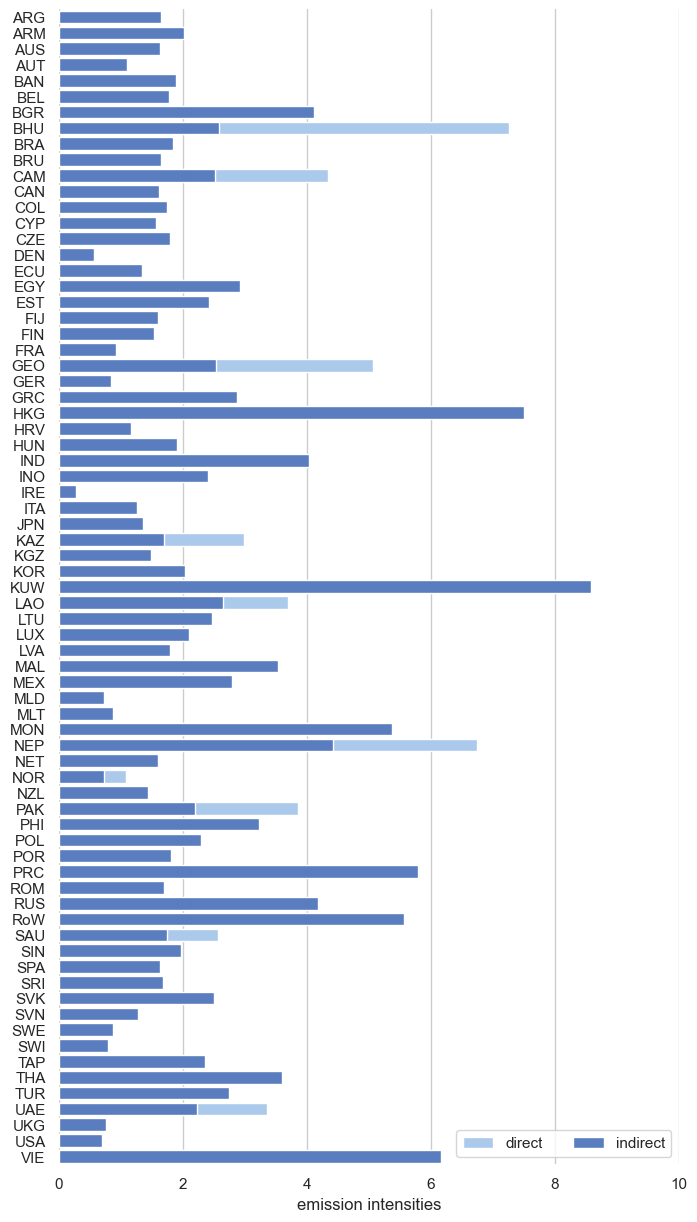

In [422]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="d_ei", y="country", data=agg_df,
            label="direct", color="b", errorbar=None)

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="i_ei", y="country", data=agg_df,
            label="indirect", color="b", errorbar=None)

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 10),
       ylabel="",
       xlabel="emission intensities")
sns.despine(left=True, bottom=True)